<a href="https://colab.research.google.com/github/TAUforPython/machinelearning/blob/for-example-and-testing/Markov%20chain%20timeseries%20reservoir%20computing%20forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install -q pyro-ppl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.6 MB/s eta 0:00:00


https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Bayesian_Neural_Networks/dl2_bnn_tut1_students_with_answers.html

In [43]:
import pyro
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
import pyro.distributions as dist

from pyro.nn import PyroModule, PyroSample

In [33]:
class TorchModel(torch.nn.Module):
    """
    Deterministic model

    :param list widths: List of layers' widths.
    :param string activation: String specifying the activation function to use.
    """
    def __init__(self, widths, activation, dropout=False, p=0.0, quantiles=None):
        super().__init__()
        self.layers = torch.nn.ModuleList()

        if activation == "tanh":
            a = torch.nn.Tanh()
        elif activation == "relu":
            a = torch.nn.ReLU()
        else:
            raise ValueError(f"{activation} not defined.")

        dp = torch.nn.Dropout(p)

        if dropout:
            self.layers.append(dp)
        for i in range(len(widths)-2):
            self.layers.append(torch.nn.Linear(widths[i], widths[i+1]))
            self.layers.append(a)
            if dropout:
                self.layers.append(dp)

        output = widths[-1] if quantiles==None else len(quantiles)
        self.layers.append(torch.nn.Linear(widths[-2], output))

    def forward(self, x):
        for f in self.layers:
            x = f(x)
        return x


class BayesianModel(PyroModule):
    """
    Probabilistic model built from a TorchModel

    :param torch_model: TorchModel object to transform into probabilistic model.
    :param config: Configuration settings.
    :param string device: String specifying the device to use, 'cpu' or 'cuda'.
    """
    def __init__(self, torch_model, config, device):
        super().__init__()

        self.device = device
        self.config = config
        self.model = torch_model

        self.distributions = self._get_priors()

        self._torch2pyro()


    def forward(self, x, y=None):
        mean = self.model(x).squeeze(-1)

        sigma = pyro.sample("sigma", self.distributions[-2]).to(self.device)

        # with pyro.plate("data", size=x.shape[0], subsample_size=50, device=self.device) as ind:
        with pyro.plate("data", device=self.device):
            obs = pyro.sample("obs", self.distributions[-1](mean, sigma), obs=y).to(self.device)
        return mean


    def _torch2pyro(self):
        pyro.nn.module.to_pyro_module_(self.model)

        for m in self.model.modules():
            for name, value in list(m.named_parameters(recurse=False)):
                setattr(m, name, PyroSample(self.distributions[0].expand(value.shape).to_event(value.dim())))


    def _get_priors(self):
        distributions = []
        distr_list = self.config['distributions']
        param_list = self.config['parameters']

        for i in range(len(distr_list)):
            if distr_list[i] == "gauss":
                try:
                    p = param_list[i]
                except:
                    distributions.append(dist.Normal)
                else:
                    distributions.append(dist.Normal(torch.tensor(float(p[0]), device=self.device),
                                                    torch.tensor(float(p[1]), device=self.device)))

            elif distr_list[i] == "unif":
                try:
                    p = param_list[i]
                except:
                    distributions.append(dist.Uniform)
                else:
                    distributions.append(dist.Uniform(torch.tensor(float(p[0]), device=self.device),
                                                    torch.tensor(float(p[1]), device=self.device)))

            elif distr_list[i] == "lapl":
                try:
                    p = param_list[i]
                except:
                    distributions.append(dist.Laplace)
                else:
                    distributions.append(dist.Laplace(torch.tensor(float(p[0]), device=self.device),
                                                    torch.tensor(float(p[1]), device=self.device))) # >0

            else:
                raise ValueError(f"{distr_list[i]['name']} prior distribution not defined.")

        return distributions


    def render_model(self, model_args, filename=None):
        return pyro.render_model(self, model_args, render_distributions=True, filename=filename)


class BayesianLinear_m(PyroModule):
    """
    Linear Bayesian model with no activations for SSVS built "manually"
    """
    def __init__(self, in_features, out_features, device, sigma=1.):
        super().__init__()

        mu = torch.tensor(0., device=device)
        sigma = torch.tensor(sigma, device=device)

        self.weights = PyroSample(dist.Normal(mu, sigma).expand((in_features, out_features)).to_event(2))
        self.bias = PyroSample(dist.Normal(mu, sigma).expand((out_features,)).to_event(1))

    def forward(self, x):
        return x @ self.weights + self.bias


class BayesianLinear_t(PyroModule):
    """
    Linear Bayesian model with no activations for SSVS using torch.nn.Linear
    """
    def __init__(self, in_features, out_features, device, sigma=1.):
        super().__init__()

        mu = torch.tensor(0., device=device)
        sigma = torch.tensor(sigma, device=device)

        self.linear = torch.nn.Sequential(torch.nn.Linear(in_features, out_features)).to(device)
        pyro.nn.module.to_pyro_module_(self.linear)

        setattr(self.linear[0].weight, 'weight', PyroSample(dist.Normal(mu, torch.tensor(1., device=device)).expand([in_features, out_features]).to_event(2)))
        setattr(self.linear[0].bias, 'bias', PyroSample(dist.Normal(mu, sigma).expand([out_features]).to_event(1)))

    def forward(self, x):
        return self.linear(x)


class HorseshoeSSVS(PyroModule):
    """
    SSVS implemented with an horseshoe continuous RV
    """
    def __init__(self, activation, device):
        super().__init__()

        self.device = device

        if activation == "tanh":
            self.a = torch.nn.Tanh()
        elif activation == "relu":
            self.a = torch.nn.ReLU()
        else:
            raise ValueError(f"{activation} not defined.")

    def forward(self, x, y=None):
        tau = pyro.sample("tau", dist.HalfCauchy(1.)).to(self.device)
        lamb = pyro.sample("lamb", dist.HalfCauchy(1.)).expand(x.shape[1]).to(self.device)
        sig = (lamb*tau)**2
        gamma = pyro.sample("gamma", dist.Normal(0, sig)).to(self.device)

        mean = self.a(x @ gamma)
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.)).to(self.device)

        with pyro.plate("data", x.shape[0], device=self.device):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)

        return mean

In [11]:

from ESN.utils import run_esn

ModuleNotFoundError: No module named 'inference'

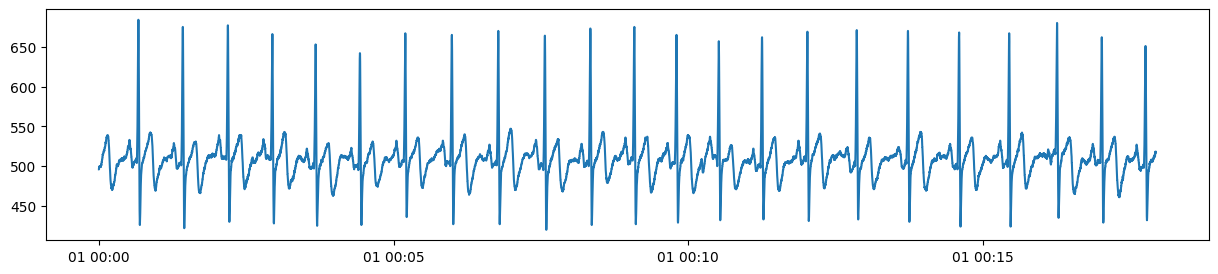

In [7]:
data_path = 'https://github.com/TAUforPython/BioMedAI/raw/refs/heads/main/test_datasets/ecg_1d_timeseries_prediction.csv'
data = pd.read_csv(data_path, delimiter=';')
data = data.rename(columns={"time":"timestamp"})
data['timestamp'] = pd.to_datetime(data['timestamp'],unit='m')
data = data.rename(columns = {'ecg_value':'target'})

plt.rcParams["figure.figsize"] = (15,3)

plt.plot(data['timestamp'],data['target'])

In [20]:
config = {
            "dataset": "spain",
            "model_widths": [512, 1],
            "activation": "tanh",
            "distributions": ["unif", "unif", "gauss"],
            "parameters": [[0,1],[0,10]],
            "dim_reduction": False,
            "num_chains": 2,
            "num_samples": 8000,
            "inference": "mcmc",
            "plot": False,
            "sweep": False
            }

Run ESN on dataset and produce embeddings with or without dimensionality reduction according to `dim_reduction`

In [ ]:
def load_spain():
    """
    Spanish energy market daily data.
    Source: https://www.kaggle.com/code/manualrg/daily-electricity-demand-forecast-machine-learning/data
    """

    spain_power_data = np.genfromtxt('dataset/spain_energy_market.csv', delimiter=',', dtype=None, encoding=None)
    data = spain_power_data[...,5] # select column with values
    data = data[spain_power_data[...,2] == 'Demanda real'] # select energy demand values
    data = data.astype(float) # convert into floats

    seasonality = 7 # 1 week
    forecast_horizon = 1 # 1 week

    return data, seasonality, forecast_horizon

In [ ]:
def run_esn(dataset, device, dim_reduction=True):
    """
    Run ESN and returns either the reservoir states, or the embeddings produce by dimensionality reduction
    """

    data, L, F = load_dataset(dataset)


    # Set ESN hyperparams
    config = json.load(open('ESN/configs/ESN_hyperparams.json', 'r'))

    Xtr, Ytr, Xval, Yval, Xte, Yte, diffXte, diffYte = generate_datasets(data, L, F, test_percent = 0.25, val_percent = 0.25)
    print("Tr: {:d}, Val: {:d}, Te: {:d}".format(Xtr.shape[0], Xval.shape[0], Xte.shape[0]))

    # Train and compute predictions
    # Use the ´_states´ variable if you want the embedding to be the identity
    Yte_pred, _, train_states, train_embedding, val_states, val_embedding, test_states, test_embedding = esnet.run_from_config_return_states(Xtr, Ytr,
                                                                                                                Xte, Yte,
                                                                                                                config,
                                                                                                                validation=True,
                                                                                                                Xval=Xval,
                                                                                                                Yval=Yval)

    if dim_reduction==True:
        # Return emedding of states via some dimensionality reduction technique
        return to_torch(Ytr, device).squeeze(), to_torch(train_embedding, device), \
                to_torch(Yval, device).squeeze(), to_torch(val_embedding, device), \
                to_torch(Yte, device).squeeze(), to_torch(test_embedding, device), \
                diffXte.squeeze(), diffYte.squeeze() # to recover the original time series, with its seasonality
    else:
        # Return the raw reservoir states
        return to_torch(Ytr, device).squeeze(), to_torch(train_states, device), \
                to_torch(Yval, device).squeeze(), to_torch(val_states, device), \
                to_torch(Yte, device).squeeze(), to_torch(test_states, device), \
                diffXte.squeeze(), diffYte.squeeze() # to recover the original time series, with its seasonality


def to_torch(array, device):
    """
    Transform numpy arrays to torch tensors and move them to `device`
    """

    dtype = 'float32'
    array = array.astype(dtype)
    return from_numpy(array).to(device)

In [ ]:
Ytr, train_embedding, Yval, val_embedding, Yte, test_embedding, diffXte, diffYte = run_esn(config.dataset, device, dim_reduction=config.dim_reduction)

Tr: 907, Val: 455, Te: 455


# Markov Chain Monte Carlo


Perform SSVS on embeddings with no dimensionality reduction.

In [34]:
torch_model = TorchModel(config['model_widths'], config['activation'])
mcmc_model = BayesianModel(torch_model, config, device = torch.device('cpu'))

In [35]:
# Quantiles
quantiles = [0, 0.005]
for n in range(39):
    quantiles.append(0.025*(n+1))
quantiles.append(0.995)

In [36]:
!pip install -q pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 38.6 MB/s eta 0:00:00


In [37]:
import pytorch_lightning as pl

In [39]:
!pip install -q pytorch_forecasting

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.7/197.7 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 27.0 MB/s eta 0:00:00


In [41]:
from time import process_time
from pyro import clear_param_store
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, Predictive, MCMC, NUTS
from pyro.ops.stats import autocorrelation
from pyro.contrib.forecast.evaluate import eval_crps
from tqdm import trange
from pytorch_forecasting import DeepAR
from pytorch_lightning.loggers import TensorBoardLogger

In [42]:
def acceptance_rate(mean_accept_prob):
    """
    Convert the mean_accept_prob computed by NUTS kernel
    into a more easily interpretable acceptance rate
    """

    acc_rates = []

    for c in mean_accept_prob:
        acc_rate = []
        for n in range(len(c)):
            acc_rate.append((n+1)*c[n] - n*c[n-1])
        acc_rates.append(acc_rate)

    return np.asarray(acc_rates)


def check_convergence(samples, acc_rate, inference_name, plot=False):
    """
    Check convergence with two methods:
    - via trace plots: where the rate of change becomes stable around zero
    - via Gelman-Rubin factor: where it goes below 1.1
    """

    print("Checking convergence...")
    if plot:
        print("Creating trace plots...")

    # Using trace plots
    conv = []

    for s in range(len(samples)):
        for name, param in samples[s].items():
            param = param.squeeze()

            if param.dim()==3:
                for i in range(param.shape[1]):
                    for j in range(param.shape[2]):
                        conv.append(trace_plot(param[:,i,j].cpu(), name + f"_{i}-{j}", plot, inference_name, s))
            elif param.dim()==2:
                for i in range(param.shape[1]):
                    conv.append(trace_plot(param[:,i].cpu(), name + f"_{i}", plot, inference_name, s))
            elif param.dim()==1:
                conv.append(trace_plot(param.cpu(), name, plot, inference_name, s))
            else:
                raise ValueError(f"Parameter {name} of dim {param.dim()}, expected 1, 2 or 3.")

        conv.append(trace_plot(acc_rate[s], "acceptance_rate", plot, inference_name, s))
        print(f"Chain {s} completed.")

    trace_plot_thr = max(conv)

    # Using Gelman-Rubin
    samples_val = [] # store sample values for each chain
    samples_key = list(samples[0].keys()) # store parameters' names

    for s in samples:
        samples_val.append(list(s.values()))

    r_hats = []
    ess = []
    size = 500
    step = 100
    for p in range(len(samples_val[0])):
        r_hats.append(gelman_rubin(torch.stack([l[p].cpu() for l in samples_val]).unfold(1,size,step),
                                   chain_dim=0, sample_dim=-1))
        # compute also effective sample size
        ess.append(effective_sample_size(torch.stack([l[p].cpu().squeeze() for l in samples_val]),
                                   chain_dim=0, sample_dim=-1))

    r_max = []
    for r in r_hats:
        r_tmp = r.squeeze()
        while r_tmp.dim() > 1:
            r_tmp = r_tmp.max(dim=-1)[0].squeeze()
        r_max.append(r_tmp)

    r_max = torch.stack(r_max)

    gelman_rubin_thr = r_hat_plot(r_max.cpu().numpy(), samples_key, plot, inference_name)

    # Return the threshold found with Gelman-Rubin,
    # samples as dictionary after cutting them at gelman_rubin_thr,
    # the last GR factor for each parameter,
    # effective sample size for each parameter
    samples_dict = {samples_key[k] : torch.cat([c[k][gelman_rubin_thr:] for c in samples_val]) for k in range(len(samples_key))}
    GR_dict = {samples_key[k] : r_max[k,-1] for k in range(len(samples_key))}
    ess_dict = {samples_key[k]: ess[k] for k in range(len(samples_key))}

    return trace_plot_thr, gelman_rubin_thr, samples_dict, GR_dict, ess_dict


def trace_plot(variable, name, plot, inference_name, chain_id):
    # Compute a moving average of the rate of change of ´variable´
    r = np.diff(variable)
    av_r = np.convolve(r, np.ones(50)/50, mode='valid')
    x = np.asarray(range(len(av_r)))

    # Change color when ´av_r´ goes below 10%
    cond = np.abs(av_r/(np.max(av_r)-np.min(av_r)))<0.10
    col = np.where(cond, 'r', 'b')

    # Threshold for convergence set where ´av_r´ is consistently under 10%
    t = len(cond) - np.argmin(np.flip(cond))

    # Create the two plots
    if plot:
        fig, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False, figsize=(15,10))
        ax1.set_title(f"{name} trace plot - chain {chain_id}")
        ax1.grid()
        ax1.plot(variable)
        ax1.vlines(t, ymin=variable.min(), ymax=variable.max(), colors='g', linestyles='dashed', label="Convergence point")
        ax2.set_title("Moving average of the rate of change")
        ax2.grid()
        ax2.scatter(x, av_r, color=col)
        ax2.vlines(t, ymin=av_r.min(), ymax=av_r.max(), colors='g', linestyles='dashed', label="Convergence point")

        # Save plots
        save_path = f'./results/plots/{inference_name}/convergence/{chain_id}/'
        Path(save_path).mkdir(parents=True, exist_ok=True) # create folder if it does not exist
        plt.savefig(f'{save_path}{name}.png')
        plt.close(fig)

    return t


def r_hat_plot(r_max, name, plot, inference_name):

    # Find where r_hat becomes consistently smaller than 1.1
    cond = r_max<1.1
    t = cond.shape[1] - max(np.min(np.argmin(np.flip(cond, axis=-1), axis=-1)), 1000)
    t = max(t, 0)

    if plot:
        plt.figure(figsize=(15,5))
        plt.title(f"Gelman-Rubin factor")
        plt.yscale('log')
        plt.ylabel(r"$\hat{R}$")
        plt.xlabel("steps")
        plt.grid()
        plt.plot(r_max.T)
        plt.hlines(y=1, xmin=0, xmax=r_max.shape[1]-1, colors='g', linestyles='dashed', label=r"$\hat{R}=1$")
        plt.vlines(t, ymin=r_max.min(), ymax=r_max.max(), colors='b', linestyles='dashed', label="Convergence point")
        plt.legend(name)

        # Save plots
        save_path = f'./results/plots/{inference_name}/convergence/gelman_rubin/'
        Path(save_path).mkdir(parents=True, exist_ok=True) # create folder if it does not exist
        plt.savefig(f'{save_path}gelman_rubin.png')
        plt.close()

    return t


def compute_coverage_len(y_test, y_lower, y_upper):
    """
    Compute average coverage and length of prediction intervals
    """
    coverage = np.mean((y_test >= y_lower) & (y_test <= y_upper))
    avg_length = np.mean(abs(y_upper - y_lower))
    avg_length = avg_length/(y_test.max()-y_test.min())

    return coverage, avg_length


def plot_forecast(predictive, Y, diffXte, diffYte, CI, name, length=200):

    # draw and compute the confidence interval CI
    target_interval = CI[1] - CI[0]
    q_low, q_hi = np.quantile(predictive["obs"].cpu().numpy().squeeze(), CI, axis=0) # 40-quantile
    mean = np.mean(predictive["obs"].cpu().numpy().squeeze(), axis=0)

    fig = plt.figure(figsize=(15,5))
    plt.plot((Y.cpu()+diffYte)[:length], label='true value', color='k')
    plt.fill_between(np.arange(predictive["obs"].shape[1])[:length], (q_low+diffYte)[:length], (q_hi+diffYte)[:length], alpha=0.3, label='0.95 PI')
    plt.plot((mean+diffYte)[:length], label='prediction')
    plt.legend(loc='best')
    plt.grid()

    # Show and save plot
    save_path = f'./results/plots/'
    Path(save_path).mkdir(parents=True, exist_ok=True) # create folder if it does not exist
    plt.savefig(f'{save_path}{name}.png')
    plt.show()
    plt.close(fig)

    pass


def check_calibration(q, Y, quantiles):
    """
    It computes the calibration error according to formula (9)
    of paper https://arxiv.org/pdf/1807.00263.pdf
    """

    # Compute predicted CDF
    predicted_cdf = np.mean(Y.cpu().numpy().squeeze() <= q, axis=1)

    # Compute calibration error
    w = 1
    cal_error = np.sum(w*(predicted_cdf-quantiles)**2)

    return cal_error, predicted_cdf


def calibrate(predictive, predictive2, Y, Y2, quantiles, folder, plot=False):
    """
    Function that computes the calibration error on the test dataset,
    train a calibrator on the evaluation dataset and check again the
    error on test dataset (or vice versa)
    """

    # Check calibration on first dataset
    q = np.quantile(predictive, quantiles, axis=0)
    cal_error, unc_cdf = check_calibration(q, Y, quantiles)

    # Calibrate on second dataset
    # Compute predicted CDF
    q2 = np.quantile(predictive2, quantiles, axis=0)
    predicted_cdf = np.mean(Y2.cpu().numpy().squeeze() <= q2, axis=1)

    # Fit calibrator
    isotonic = IsotonicRegression(out_of_bounds='clip')
    isotonic.fit(predicted_cdf, quantiles)

    # Check again calibration on first dataset
    new_quantiles = isotonic.transform(quantiles)
    new_q = np.quantile(predictive, new_quantiles, axis=0)
    new_cal_error, cal_cdf = check_calibration(new_q, Y, quantiles)

    if plot:
        ax = plt.figure(figsize=(6, 6))
        ax = plt.gca()
        # ax.plot(new_quantiles, predicted_cdf, '-s', color='green', label='Cal data')
        ax.plot(quantiles, unc_cdf, '-x', color='purple', label='Uncalibrated')
        ax.plot(quantiles, cal_cdf, '-+', color='red', label='Calibrated')
        ax.plot([0,1],[0,1],'--', color='grey', label='Perfect calibration')
        ax.set_xlabel('Predicted', fontsize=17)
        ax.set_ylabel('Empirical', fontsize=17)
        ax.set_title('Predicted CDF vs Empirical CDF', fontsize=17)
        ax.legend(fontsize=10)

        save_path = './results/plots/' + folder + '/'
        Path(save_path).mkdir(parents=True, exist_ok=True) # create folder if it does not exist
        plt.savefig(f'{save_path}' + 'calibration' + '.png')
        plt.clf()

    return cal_error, new_cal_error, new_quantiles


def num_eval_crps(quantiles, tau, y):
    """
    It computes a discrete version of the CRPS
    so to use it to evaluate quantile regression
    """

    q = np.asarray(quantiles)[:,np.newaxis]
    H = np.heaviside(tau-y, 0)
    dx = np.asarray([tau[i+1,:] - tau[i,:] for i in range(tau.shape[0]-1)])
    crps = np.mean(np.sum(dx*((q-H)[1:,:]**2), 0))

    return crps

In [ ]:


from inference.bayesian.utils import check_convergence, acceptance_rate, calibrate, compute_coverage_len, num_eval_crps
from inference.early_stopping import EarlyStopping




In [44]:

#########################################
#           Variational Inference       #
#########################################

def train_SVI(model, guide, X, Y, lr=0.03, num_iterations=120):

    optim = Adam({"lr": lr})
    svi = SVI(model, guide, optim, loss=Trace_ELBO())

    # Clear the param store first, if it was already used
    clear_param_store()

    start_time = process_time()

    with trange(num_iterations) as t:
        for j in t:
            # calculate the loss and take a gradient step
            loss = svi.step(X, Y)

            # display progress bar
            t.set_description(f"Epoch {j+1}")
            t.set_postfix({"loss":loss / Y.shape[0]})

    train_time = process_time() - start_time

    guide.requires_grad_(False)

    diagnostics = {
        "train_time": train_time,
        "final_loss": loss / Y.shape[0]
    }

    return diagnostics


def pred_SVI(model, guide, X_val, Y_val, X_test, Y_test, num_samples, plot, sweep, diagnostics, quantiles):

    # Use validation set for hyperparameters tuning
    if sweep:
        X, Y = X_val, Y_val
        X2, Y2 = X_test, Y_test
    else:
        X, Y = X_test, Y_test
        X2, Y2 = X_val, Y_val

    # Perform inference
    start_time = process_time()
    predictive = Predictive(model, guide=guide, num_samples=num_samples)(x=X, y=None)
    inference_time = process_time() - start_time
    diagnostics["inference_time"] = inference_time

    # Compute calibration error
    predictive2 = Predictive(model, guide=guide, num_samples=num_samples)(x=X2, y=None)
    # Calibrate
    cal_error, new_cal_error, new_quantiles = calibrate(predictive["obs"].cpu().numpy().squeeze(),
                                                        predictive2["obs"].cpu().numpy().squeeze(),
                                                        Y, Y2, quantiles, folder="svi", plot=plot)
    diagnostics["cal_error"] = cal_error
    diagnostics["new_cal_error"] = new_cal_error
    diagnostics["quantiles"] = quantiles
    diagnostics["new_quantiles"] = new_quantiles

    # Width at 0.95 quantile
    q_low, q_hi = np.quantile(predictive["obs"].cpu().numpy().squeeze(), [quantiles[2], quantiles[-2]], axis=0) # 40-quantile
    diagnostics["width"] = np.mean(q_hi - q_low)
    # After calibration
    new_q_low, new_q_hi = np.quantile(predictive["obs"].cpu().numpy().squeeze(), [new_quantiles[2], new_quantiles[-2]], axis=0) # 40-quantile
    diagnostics["new_width"] = np.mean(new_q_hi - new_q_low)

    # Check coverage with 95% quantiles
    coverage, avg_length = compute_coverage_len(Y.cpu().numpy(), q_low, q_hi)
    diagnostics["coverage"] = coverage
    diagnostics["avg_length"] = avg_length
    # Re-compute after calibration
    coverage, avg_length = compute_coverage_len(Y.cpu().numpy(), new_q_low, new_q_hi)
    diagnostics["new_coverage"] = coverage
    diagnostics["new_avg_length"] = avg_length

    # Mean Squared Error wrt the median
    median = np.quantile(predictive["obs"].cpu().numpy().squeeze(), quantiles[int(len(quantiles)/2)], axis=0) # median
    mse = np.mean((median-Y.cpu().numpy())**2)
    diagnostics["mse"] = mse
    # After calibration
    median = np.quantile(predictive["obs"].cpu().numpy().squeeze(), new_quantiles[int(len(new_quantiles)/2)], axis=0) # median
    mse = np.mean((median-Y.cpu().numpy())**2)
    diagnostics["new_mse"] = mse

    # Numerical continuous ranked probability score
    tau = np.quantile(predictive["obs"].cpu().numpy().squeeze(), quantiles, axis=0)
    n_crps = num_eval_crps(quantiles, tau, Y.cpu().squeeze().numpy())
    diagnostics["crps"] = n_crps
    # Compute CRPS after calibration
    tau = np.quantile(predictive["obs"].cpu().numpy().squeeze(), new_quantiles, axis=0)
    new_n_crps = num_eval_crps(new_quantiles, tau, Y.cpu().squeeze().numpy())
    diagnostics["new_crps"] = new_n_crps

    return predictive, diagnostics



#########################################
#       Monte Carlo Markov Chain        #
#########################################


def train_MCMC(model, X, Y, num_chains, num_samples, sweep):

    # Define a hook to log the acceptance rate and step size at each iteration
    step_size = []
    acc_rate = []
    def acc_rate_hook(kernel, params, stage, i):
        step_size.append(kernel.step_size) # Log step_size
        # _mean_accept_prob contains the acceptance probability
        # averaged over the time step n
        acc_rate.append(kernel._mean_accept_prob) # Log acceptance rate

    # Using num_chains>1 on the CPU affects memory performances,
    # on GPU the multiprocessing doesn't seem to work properly
    # so we run multiple chains sequentially

    samples = []
    train_time = []

    for n in range(num_chains):
        # Use NUTS kernel
        nuts_kernel = NUTS(model)

        mcmc = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=0, num_chains=1, hook_fn=acc_rate_hook)

        # Run the MCMC and compute the training time
        start_time = process_time()
        mcmc.run(X, Y)
        train_time.append(process_time() - start_time)

        # temp_samples = {k: v.cpu() for k, v in mcmc.get_samples().items()}

        samples.append(mcmc.get_samples())

    step_size = np.asarray(step_size).reshape((num_chains,num_samples))
    acc_rate = acceptance_rate(np.asarray(acc_rate).reshape((num_chains,num_samples)))

    # Compute autocorrelation for each chain and each parameter separately
    autocorrs = []
    # if not sweep:
    #     for chain in samples:
    #         autocorr = {}
    #         for k, v in chain.items():
    #             autocorr[k] = autocorrelation(v)
    #         autocorrs.append(autocorr)

    # Save diagnostics in dict
    diagnostics = {
        "step_size": step_size,
        "acceptance_rate": acc_rate,
        "train_time": np.asarray(train_time).mean(),
        "autocorrelation": autocorrs
    }

    return samples, diagnostics


def pred_MCMC(model, samples, X_val, Y_val, X_test, Y_test, plot, sweep, diagnostics, inference_name, quantiles):

    # Use validation set for hyperparameters tuning
    if sweep:
        X, Y = X_val, Y_val
        X2, Y2 = X_test, Y_test
    else:
        X, Y = X_test, Y_test
        X2, Y2 = X_val, Y_val

    # Find when it converged
    acc_rate = diagnostics["acceptance_rate"]
    _, warmup, samples, GR_factors, ess = check_convergence(samples, acc_rate, inference_name, plot)
    print(f"MCMC converged at {warmup} steps.")

    diagnostics["gelman_rubin"] = GR_factors
    diagnostics["effective_sample_size"] = ess

    # Perform inference
    predictive = Predictive(model, samples)(x=X, y=None)

    # Quantiles
    target_interval = 0.95  # draw and compute the 95% confidence interval
    q_low, q_hi = np.quantile(predictive["obs"].cpu().numpy().squeeze(), [(1-target_interval)/2, 1-(1-target_interval)/2], axis=0) # 40-quantile
    diagnostics["width95"] = q_hi - q_low

    target_interval = 0.99  # draw and compute the 99% confidence interval
    q_low, q_hi = np.quantile(predictive["obs"].cpu().numpy().squeeze(), [(1-target_interval)/2, 1-(1-target_interval)/2], axis=0) # 40-quantile
    diagnostics["width99"] = q_hi - q_low

    # Mean Squared Error
    mean = np.mean(predictive["obs"].cpu().numpy().squeeze(), axis=0)
    mse = np.mean((mean-Y.cpu().numpy())**2)
    diagnostics["mse"] = mse

    # Compute calibration error
    predictive2 = Predictive(model, samples)(x=X2, y=None)
    # Calibrate
    cal_error, new_cal_error, new_quantiles = calibrate(predictive["obs"].cpu().numpy().squeeze(),
                                                        predictive2["obs"].cpu().numpy().squeeze(),
                                                        Y, Y2, quantiles, folder=inference_name, plot=plot)
    diagnostics["cal_error"] = cal_error
    diagnostics["new_cal_error"] = new_cal_error
    diagnostics["quantiles"] = quantiles
    diagnostics["new_quantiles"] = new_quantiles

    # Width at 0.95 quantile
    q_low, q_hi = np.quantile(predictive["obs"].cpu().numpy().squeeze(), [quantiles[2], quantiles[-2]], axis=0) # 40-quantile
    diagnostics["width"] = np.mean(q_hi - q_low)
    # After calibration
    new_q_low, new_q_hi = np.quantile(predictive["obs"].cpu().numpy().squeeze(), [new_quantiles[2], new_quantiles[-2]], axis=0) # 40-quantile
    diagnostics["new_width"] = np.mean(new_q_hi - new_q_low)

    # Check coverage with 95% quantiles
    coverage, avg_length = compute_coverage_len(Y.cpu().numpy(), q_low, q_hi)
    diagnostics["coverage"] = coverage
    diagnostics["avg_length"] = avg_length
    # Re-compute after calibration
    coverage, avg_length = compute_coverage_len(Y.cpu().numpy(), new_q_low, new_q_hi)
    diagnostics["new_coverage"] = coverage
    diagnostics["new_avg_length"] = avg_length

    # Mean Squared Error wrt the median
    median = np.quantile(predictive["obs"].cpu().numpy().squeeze(), quantiles[int(len(quantiles)/2)], axis=0) # median
    mse = np.mean((median-Y.cpu().numpy())**2)
    diagnostics["mse"] = mse
    # After calibration
    median = np.quantile(predictive["obs"].cpu().numpy().squeeze(), new_quantiles[int(len(new_quantiles)/2)], axis=0) # median
    mse = np.mean((median-Y.cpu().numpy())**2)
    diagnostics["new_mse"] = mse

    # # Empirical continuous ranked probability score
    # e_crps = eval_crps(predictive['obs'], Y.squeeze())
    # diagnostics["e_crps"] = e_crps
    # Numerical continuous ranked probability score
    tau = np.quantile(predictive["obs"].cpu().numpy().squeeze(), quantiles, axis=0)
    n_crps = num_eval_crps(quantiles, tau, Y.cpu().squeeze().numpy())
    diagnostics["crps"] = n_crps
    # Compute CRPS after calibration
    tau = np.quantile(predictive["obs"].cpu().numpy().squeeze(), new_quantiles, axis=0)
    new_n_crps = num_eval_crps(new_quantiles, tau, Y.cpu().squeeze().numpy())
    diagnostics["new_crps"] = new_n_crps

    return predictive, diagnostics



########################
#       Dropout        #
########################


def train_DO(model, X, Y, X_val, Y_val, lr, epochs):

    torch_optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    mse_loss = torch.nn.MSELoss()

    # initialize the early_stopping object
    checkpoint_path = "./checkpoints/DO/"
    early_stopping = EarlyStopping(patience=20, verbose=False, path=checkpoint_path)

    start_time = process_time()

    with trange(epochs) as t:
        for epoch in t:
            model.train()
            torch_optimizer.zero_grad()
            loss = mse_loss(model(X).squeeze(), Y)
            loss.backward()
            torch_optimizer.step()

            # display progress bar
            t.set_description(f"Epoch {epoch+1}")
            t.set_postfix({"loss":float(loss / Y.shape[0])})

            # Early stopping
            model.eval()
            valid_loss = mse_loss(model(X_val), Y_val).item()

            # early_stopping needs the validation loss to check if it has decresed,
            # and if it has, it will make a checkpoint of the current model
            early_stopping(valid_loss, model)

            model.train()

            if early_stopping.early_stop:
                print("Early stopping")
                break

    train_time = process_time() - start_time

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load(checkpoint_path + "checkpoint.pt"))

    diagnostics = {
        "train_time": train_time,
        "final_loss": float((loss / Y.shape[0]).detach().cpu())
    }

    return diagnostics


def pred_DO(model, X_val, Y_val, X_test, Y_test, num_samples, plot, sweep, diagnostics, quantiles):

    # Use validation set for hyperparameters tuning
    if sweep:
        X, Y = X_val, Y_val
        X2, Y2 = X_test, Y_test
    else:
        X, Y = X_test, Y_test
        X2, Y2 = X_val, Y_val

    # Perform inference
    start_time = process_time()
    predictive = []
    for n in range(num_samples):
        predictive.append(model(X).detach().cpu().squeeze())
    predictive = np.stack(predictive, axis=0)
    inference_time = process_time() - start_time
    diagnostics["inference_time"] = inference_time

    # Compute calibration error
    predictive2 = []
    for n in range(num_samples):
        predictive2.append(model(X2).detach().cpu().squeeze())
    predictive2 = np.stack(predictive2, axis=0)

    # Calibrate
    cal_error, new_cal_error, new_quantiles = calibrate(predictive, predictive2, Y, Y2, quantiles, folder="dropout", plot=plot)
    diagnostics["cal_error"] = cal_error
    diagnostics["new_cal_error"] = new_cal_error
    diagnostics["quantiles"] = quantiles
    diagnostics["new_quantiles"] = new_quantiles

    # Width at 0.95 quantile
    q_low, q_hi = np.quantile(predictive, [quantiles[2], quantiles[-2]], axis=0) # 40-quantile
    diagnostics["width"] = np.mean(q_hi - q_low)
    # After calibration
    new_q_low, new_q_hi = np.quantile(predictive, [new_quantiles[2], new_quantiles[-2]], axis=0) # 40-quantile
    diagnostics["new_width"] = np.mean(new_q_hi - new_q_low)

    # Width at 0.70 quantile
    q_low70, q_hi70 = np.quantile(predictive, [quantiles[7], quantiles[-7]], axis=0) # 40-quantile
    diagnostics["width70"] = np.mean(q_hi70 - q_low70)
    # After calibration
    new_q_low70, new_q_hi70 = np.quantile(predictive, [new_quantiles[7], new_quantiles[-7]], axis=0) # 40-quantile
    diagnostics["new_width70"] = np.mean(new_q_hi70 - new_q_low70)

    # Check coverage with 95% quantiles
    coverage, avg_length = compute_coverage_len(Y.cpu().numpy(), q_low, q_hi)
    diagnostics["coverage"] = coverage
    diagnostics["avg_length"] = avg_length
    # Re-compute after calibration
    coverage, avg_length = compute_coverage_len(Y.cpu().numpy(), new_q_low, new_q_hi)
    diagnostics["new_coverage"] = coverage
    diagnostics["new_avg_length"] = avg_length

    # Check coverage with 70% quantiles
    coverage70, avg_length70 = compute_coverage_len(Y.cpu().numpy(), q_low70, q_hi70)
    diagnostics["coverage70"] = coverage70
    diagnostics["avg_length70"] = avg_length70
    # Re-compute after calibration
    coverage70, avg_length70 = compute_coverage_len(Y.cpu().numpy(), new_q_low70, new_q_hi70)
    diagnostics["new_coverage70"] = coverage70
    diagnostics["new_avg_length70"] = avg_length70

    # Mean Squared Error wrt the median
    median = np.quantile(predictive, quantiles[int(len(quantiles)/2)], axis=0) # median
    mse = np.mean((median-Y.cpu().numpy())**2)
    diagnostics["mse"] = mse
    # After calibration
    median = np.quantile(predictive, new_quantiles[int(len(new_quantiles)/2)], axis=0) # median
    mse = np.mean((median-Y.cpu().numpy())**2)
    diagnostics["new_mse"] = mse

    # # Empirical continuous ranked probability score
    # e_crps = eval_crps(torch.from_numpy(predictive).cpu(), Y.cpu().squeeze())
    # diagnostics["e_crps"] = e_crps
    # Numerical continuous ranked probability score
    tau = np.quantile(predictive, quantiles, axis=0)
    n_crps = num_eval_crps(quantiles, tau, Y.cpu().squeeze().numpy())
    diagnostics["crps"] = n_crps
    # Compute CRPS after calibration
    tau = np.quantile(predictive, new_quantiles, axis=0)
    new_n_crps = num_eval_crps(new_quantiles, tau, Y.cpu().squeeze().numpy())
    diagnostics["new_crps"] = new_n_crps

    predictive_dict = {"obs": torch.from_numpy(predictive)}

    return predictive_dict, diagnostics



#########################################
#                 DeepAR                #
#########################################


def train_deepAR(model, train_dataloader, val_dataloader, epochs, device):

    accelerator = "gpu" if device.type == "cuda" else "cpu"
    model = model.to(device)

    early_stop_callback = pl.callbacks.early_stopping.EarlyStopping(
        monitor="val_loss", min_delta=1e-6, patience=20,
        verbose=False, mode="min")

    logger = TensorBoardLogger("logs", "DeepAR")

    trainer = pl.Trainer(
        max_epochs=epochs,
        accelerator=accelerator,
        enable_model_summary=True,
        gradient_clip_val=0.2,
        callbacks=[early_stop_callback],
        limit_train_batches=50,
        enable_checkpointing=True,
        logger=logger
    )

    start_time = process_time()
    trainer.fit(
        model,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )
    train_time = process_time() - start_time

    best_model_path = trainer.checkpoint_callback.best_model_path
    best_model = DeepAR.load_from_checkpoint(best_model_path)

    diagnostics = {
        "train_time": train_time,
        "final_loss": np.nan
    }

    return best_model, diagnostics


def pred_deepAR(model, val_dataloader, test_dataloader, num_samples, horizon, plot, sweep, diagnostics, quantiles, device):

    accelerator = "cuda" if device.type == "cuda" else "cpu"
    model = model.to(device)

    # Use validation set for hyperparameters tuning
    if sweep:
        dataloader1 = val_dataloader
        dataloader2 = test_dataloader
    else:
        dataloader1 = test_dataloader
        dataloader2 = val_dataloader

    # Perform inference
    start_time = process_time()
    predictive = model.predict(dataloader1, mode="raw", return_x=False, n_samples=num_samples,
                               trainer_kwargs=dict(accelerator=accelerator), return_y=True)
    inference_time = process_time() - start_time
    diagnostics["inference_time"] = inference_time

    Y = predictive.y[0][0,horizon-1::horizon]
    predictive = predictive.output["prediction"][:,-1,:].T
    predictive_dict = {"obs": predictive, "y": Y}

    # Compute calibration error
    predictive2 = model.predict(dataloader2, mode="raw", return_x=False, n_samples=num_samples,
                               trainer_kwargs=dict(accelerator=accelerator), return_y=True)
    Y2 = predictive2.y[0][0,horizon-1::horizon]
    predictive2 = predictive2.output["prediction"][:,-1,:].T
    # Calibrate
    cal_error, new_cal_error, new_quantiles = calibrate(predictive.cpu().numpy().squeeze(),
                                                        predictive2.cpu().numpy().squeeze(),
                                                        Y, Y2, quantiles, folder="deepar", plot=plot)
    diagnostics["cal_error"] = cal_error
    diagnostics["new_cal_error"] = new_cal_error
    diagnostics["quantiles"] = quantiles
    diagnostics["new_quantiles"] = new_quantiles

    # Width at 0.95 quantile
    q_low, q_hi = np.quantile(predictive_dict["obs"].cpu().numpy().squeeze(), [quantiles[2], quantiles[-2]], axis=0) # 40-quantile
    diagnostics["width"] = np.mean(q_hi - q_low)
    # After calibration
    new_q_low, new_q_hi = np.quantile(predictive_dict["obs"].cpu().numpy().squeeze(), [new_quantiles[2], new_quantiles[-2]], axis=0) # 40-quantile
    diagnostics["new_width"] = np.mean(new_q_hi - new_q_low)

    # Check coverage with 95% quantiles
    coverage, avg_length = compute_coverage_len(Y.cpu().numpy(), q_low, q_hi)
    diagnostics["coverage"] = coverage
    diagnostics["avg_length"] = avg_length
    # Re-compute after calibration
    coverage, avg_length = compute_coverage_len(Y.cpu().numpy(), new_q_low, new_q_hi)
    diagnostics["new_coverage"] = coverage
    diagnostics["new_avg_length"] = avg_length

    # Mean Squared Error wrt the median
    median = np.quantile(predictive_dict["obs"].cpu().numpy().squeeze(), quantiles[int(len(quantiles)/2)], axis=0) # median
    mse = np.mean((median-Y.cpu().numpy())**2)
    diagnostics["mse"] = mse
    # After calibration
    median = np.quantile(predictive_dict["obs"].cpu().numpy().squeeze(), new_quantiles[int(len(new_quantiles)/2)], axis=0) # median
    mse = np.mean((median-Y.cpu().numpy())**2)
    diagnostics["new_mse"] = mse

    # Numerical continuous ranked probability score
    tau = np.quantile(predictive_dict["obs"].cpu().numpy().squeeze(), quantiles, axis=0)
    n_crps = num_eval_crps(quantiles, tau, Y.cpu().squeeze().numpy())
    diagnostics["crps"] = n_crps
    # Compute CRPS after calibration
    tau = np.quantile(predictive_dict["obs"].cpu().numpy().squeeze(), new_quantiles, axis=0)
    new_n_crps = num_eval_crps(new_quantiles, tau, Y.cpu().squeeze().numpy())
    diagnostics["new_crps"] = new_n_crps

    return predictive_dict, diagnostics

In [45]:

def train_QR(model, X, Y, X_val, Y_val, lr, epochs, quantiles):

    torch_optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    # initialize the early_stopping object
    checkpoint_path = "./checkpoints/QR/"
    early_stopping = EarlyStopping(patience=20, verbose=False, path=checkpoint_path)

    start_time = process_time()

    with trange(epochs) as t:
        for epoch in t:
            model.train()
            torch_optimizer.zero_grad()
            loss = quantile_loss(quantiles, model(X), Y)
            loss.backward()
            torch_optimizer.step()

            # display progress bar
            t.set_description(f"Epoch {epoch+1}")
            t.set_postfix({"loss":float(loss / Y.shape[0])})

            # Early stopping
            model.eval()
            valid_loss = quantile_loss(quantiles, model(X_val), Y_val).item()

            # early_stopping needs the validation loss to check if it has decresed,
            # and if it has, it will make a checkpoint of the current model
            early_stopping(valid_loss, model)

            if early_stopping.early_stop:
                print("Early stopping")
                break

    train_time = process_time() - start_time

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load(checkpoint_path + "checkpoint.pt"))

    diagnostics = {
        "train_time": train_time,
        "final_loss": float((loss / Y.shape[0]).detach().cpu())
    }

    return diagnostics


def pred_QR(model, X_val, Y_val, X_test, Y_test, plot, sweep, diagnostics, quantiles):

    model.eval()

    # Use validation set for hyperparameters tuning
    if sweep:
        X, Y = X_val, Y_val
        X2, Y2 = X_test, Y_test
    else:
        X, Y = X_test, Y_test
        X2, Y2 = X_val, Y_val

    # Perform inference
    start_time = process_time()
    predictive = model(X).detach().squeeze()
    inference_time = process_time() - start_time
    diagnostics["inference_time"] = inference_time

    # Compute calibration error
    predictive2 = model(X2).detach().squeeze()
    # Calibrate
    # calibration doesn't make sense for QR
    cal_error, new_cal_error, new_quantiles = calibrate(predictive, predictive2, Y, Y2, quantiles, folder="q_regr", plot=plot)
    diagnostics["cal_error"] = cal_error
    diagnostics["new_cal_error"] = new_cal_error    # it does not refer to same quantiles
    diagnostics["quantiles"] = quantiles
    diagnostics["new_quantiles"] = new_quantiles

    # Width of 0.95 quantiles
    q_low = predictive[:,2].cpu().numpy()
    q_hi = predictive[:,-2].cpu().numpy()
    diagnostics["width"] = np.mean(q_hi - q_low)
    # After calibration it does not refer to same quantiles
    diagnostics["new_width"] = float('nan')

    # Check coverage with 95% quantiles
    if predictive.dim() > 1:
        coverage, avg_length = compute_coverage_len(Y.cpu().numpy(), q_low, q_hi)
        diagnostics["coverage"] = coverage
        diagnostics["avg_length"] = avg_length
        # After calibration it does not refer to same quantiles
        diagnostics["new_coverage"] = float('nan')
        diagnostics["new_avg_length"] = float('nan')

    # Mean Squared Error wrt the median
    mean_index = int(predictive.shape[1]/2)
    median = predictive[:,mean_index].cpu().numpy()
    mse = np.mean((median-Y.cpu().numpy())**2)
    diagnostics["mse"] = mse
    # After calibration it does not refer to the median
    diagnostics["new_mse"] = float('nan')

    # Continuous ranked probability score
    crps = eval_crps(quantiles, predictive.cpu().numpy(), Y.unsqueeze(dim=1).cpu().numpy())
    diagnostics["crps"] = crps
    # After calibration it does not refer to same quantiles
    diagnostics["new_crps"] = float('nan')

    return predictive, diagnostics


def quantile_loss(quantiles, output, target):
    losses = []
    for i, q in enumerate(quantiles):
        error = target-output[:,i]
        losses.append(torch.max(q*error, (q-1)*error))
    loss = torch.mean(torch.sum(torch.stack(losses), dim=-1))
    return loss



#####################################
#               ARIMA               #
#####################################


def train_ARIMA(X, start_p=1, start_q=1, max_p=4, max_q=4, d=1):

    start_time = process_time()

    # automatically fit the optimal ARIMA model for given time series
    arima_model = pmdarima.auto_arima(
        y=X,
        start_p=start_p, start_q=start_q,
        max_p=max_p, max_q=max_q,
        m=1, seasonal=False,    # seasonality already removed in pre-processing
        d=d,
        trace=False,            # no debug info
        error_action='ignore',  # don't want to know if an order does not work
        suppress_warnings=True, # don't want convergence warnings
        stepwise=True)
    print("Best model selected: ", arima_model)

    train_time = process_time() - start_time

    diagnostics = {
        "train_time": train_time,
        "final_loss": float('nan')  # couldn't find a way to retrieve final loss value
    }

    return arima_model, diagnostics


def pred_ARIMA(model, X_val, Y_val, X_test, Y_test, horizon, plot, diagnostics, quantiles):

    # Make predictions and update the model
    q_lows, q_highs = [], []

    start_time = process_time()

    X = torch.cat([X_val, X_test])

    for q1, q2 in zip(quantiles[1:len(quantiles)//2], quantiles[::-1]):
        pred_list, ci_list = [], []
        with trange(X.shape[0], desc = "CI {0:.2f}".format(q2-q1)) as t:
            for step in t:
                y_hat, conf_int = model.predict(n_periods=horizon, return_conf_int=True, alpha=q2-q1)
                model.update(X[step].unsqueeze(-1))
                pred_list.append(y_hat[-1])
                ci_list.append(conf_int[-1,:])

        # collect predictions, CI, and residuals
        preds = np.hstack(pred_list)
        preds_ci = np.vstack(ci_list)

        q_lows.append(preds_ci[:,0])
        q_highs.append(preds_ci[:,1])

    inference_time = process_time() - start_time
    diagnostics["inference_time"] = inference_time / 2  # only the time spent on val test

    # Combine all quantiles and prediction
    q_lows = np.vstack(q_lows[::-1]).T
    q_highs = np.vstack(q_highs).T

    predictive = np.hstack([q_lows, preds[:,None], q_highs])
    predictive2 = torch.from_numpy(predictive[X_val.shape[0]:,:]) # corresponding to test set
    predictive = torch.from_numpy(predictive[:X_val.shape[0],:])  # corresponding to val test

    # Compute calibration error
    # Calibrate
    cal_error, new_cal_error, new_quantiles = calibrate(predictive, predictive2, Y_val, Y_test, quantiles[1:], folder="arima", plot=plot)
    diagnostics["cal_error"] = cal_error
    diagnostics["new_cal_error"] = new_cal_error    # it does not refer to same quantiles
    diagnostics["quantiles"] = quantiles[1:]
    diagnostics["new_quantiles"] = new_quantiles

    # Width of 0.95 quantiles
    q_low = predictive[:,1].cpu().numpy()
    q_hi = predictive[:,-1].cpu().numpy()
    diagnostics["width"] = np.mean(q_hi - q_low)
    # After calibration it does not refer to same quantiles
    diagnostics["new_width"] = float('nan')

    # Check coverage with 95% quantiles
    if predictive.dim() > 1:
        coverage, avg_length = compute_coverage_len(Y_val.cpu().numpy(), q_low, q_hi)
        diagnostics["coverage"] = coverage
        diagnostics["avg_length"] = avg_length
        # After calibration it does not refer to same quantiles
        diagnostics["new_coverage"] = float('nan')
        diagnostics["new_avg_length"] = float('nan')

    # Mean Squared Error wrt the median
    mean_index = int(predictive.shape[1]/2)
    median = predictive[:,mean_index].cpu().numpy()
    mse = np.mean((median-Y_val.cpu().numpy())**2)
    diagnostics["mse"] = mse
    # After calibration it does not refer to the median
    diagnostics["new_mse"] = float('nan')

    # Continuous ranked probability score
    crps = eval_crps(quantiles[1:], predictive.cpu().numpy(), Y_val.unsqueeze(dim=1).cpu().numpy())
    diagnostics["crps"] = crps
    # After calibration it does not refer to same quantiles
    diagnostics["new_crps"] = float('nan')


    return predictive, diagnostics

In [46]:

def inference(config, model, guide, X_train, Y_train, X_val, Y_val, X_test, Y_test, quantiles=None, horizon=None, device=None):
    if config.inference == "svi":
        diagnostics = train_SVI(model, guide, X_train, Y_train, config.lr, config.num_iterations)
        predictive, diagnostics = pred_SVI(model, guide, X_val, Y_val, X_test, Y_test, config.num_samples, config.plot, config.sweep, diagnostics, quantiles)
        return predictive, diagnostics

    elif config.inference == "mcmc" or config.inference == "ssvs":
        samples, diagnostics = train_MCMC(model, X_train, Y_train, config.num_chains, config.num_samples, config.sweep)
        predictive, diagnostics = pred_MCMC(model, samples, X_val, Y_val, X_test, Y_test, config.plot, config.sweep, diagnostics, config.inference, quantiles)
        return predictive, diagnostics

    elif config.inference == "q_regr":
        diagnostics = train_QR(model, X_train, Y_train, X_val, Y_val, config.lr, config.num_iterations, quantiles)
        predictive, diagnostics = pred_QR(model, X_val, Y_val, X_test, Y_test, config.plot, config.sweep, diagnostics, quantiles)
        return predictive, diagnostics

    elif config.inference == "dropout":
        diagnostics = train_DO(model, X_train, Y_train, X_val, Y_val, config.lr, config.num_iterations)
        predictive, diagnostics = pred_DO(model, X_val, Y_val, X_test, Y_test, config.num_samples, config.plot, config.sweep, diagnostics, quantiles)
        return predictive, diagnostics

    elif config.inference == "arima":
        model, diagnostics = train_ARIMA(X_train, config.start_p, config.start_q, config.max_p, config.max_q, config.d)
        predictive, diagnostics = pred_ARIMA(model, X_val, Y_val, X_test, Y_test, horizon, config.plot, diagnostics, quantiles)
        return predictive, diagnostics

    elif config.inference == "deepar":
        model, diagnostics = train_deepAR(model, X_train, X_val, config.num_iterations, device)
        predictive, diagnostics = pred_deepAR(model, X_val, X_test, config.num_samples, horizon, config.plot, config.sweep, diagnostics, quantiles, device)
        return predictive, diagnostics

    else:
        raise ValueError(f"{config.inference} method not implemented.")



In [47]:
# Run Markov chains and collect diagnostics
predictive, diagnostics = inference(config, mcmc_model, None,
                                    X_train=train_embedding, Y_train=Ytr,
                                    X_val=val_embedding, Y_val=Yval,
                                    X_test=test_embedding, Y_test=Yte,
                                    quantiles=quantiles)

NameError: name 'train_embedding' is not defined

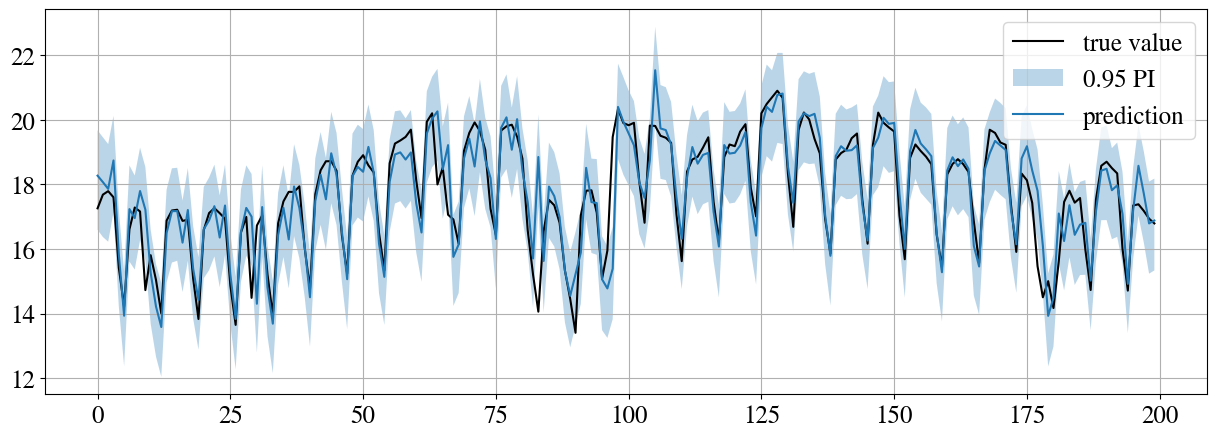

In [ ]:
CI = [diagnostics["new_quantiles"][2], diagnostics["new_quantiles"][-2]]

plot_forecast(predictive, Yte, diffXte.squeeze(), diffYte.squeeze(), CI, "mcmc")

In [ ]:
for k, v in diagnostics.items():
    print(k)

step_size
acceptance_rate
train_time
autocorrelation
gelman_rubin
effective_sample_size
width95
width99
mse
cal_error
new_cal_error
width
new_width
coverage
avg_length
new_coverage
new_avg_length
new_mse
crps
new_crps


In [ ]:
print(diagnostics['gelman_rubin'])

{'model.layers.0.bias': tensor(9.6278), 'model.layers.0.weight': tensor(53.0830), 'sigma': tensor(54.2073)}


In [ ]:
print("effective sample size: ", diagnostics['effective_sample_size'])

effective sample size:  {'model.layers.0.bias': tensor(1.0405), 'model.layers.0.weight': tensor([ 72.4706,  75.3831,  76.3006,  ...,  99.6259,  89.6037, 102.8600]), 'sigma': tensor(1.3231)}


In [ ]:
print("training time: ", diagnostics['train_time'])
# print("effective sample size: ", diagnostics['effective_sample_size'])
print("calibration error: ", diagnostics['cal_error'])
print("Continuous ranked probability score: ", diagnostics['crps'])
print("Mean Squared Error: ", diagnostics['mse'])

training time:  1017.4688439685001
calibration error:  13.754522658175986
Continuous ranked probability score:  0.2809542119503021
Mean Squared Error:  0.29989374


In [ ]:
# to reload a package or method
import sys, importlib

importlib.reload(sys.modules['bayesian.utils'])

from inference.bayesian.utils import plot_forecast

In [ ]:
# to save a session
import dill

dill.dump_session('dump/notebook_16122022.db')

In [ ]:
# to load a session
dill.load_session('notebook_env.db')

In [ ]:
predictive['obs'].shape

torch.Size([1988, 3431])